<a href="https://colab.research.google.com/github/Baze-Bai/XAI/blob/HW6/Mechanistic_Interpretability.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AIPI 590 - XAI | Mechanistic Interpretability
# Learning Deep Features for Discriminative Localization Demo Notebook
### Zejun(Baze) Bai

# The Specific Technique I'll Implement
I will implement Class Activation Mapping (CAM), a technique that visualizes which parts of an image contribute most to a CNN's decision by generating a heatmap of class-specific importance.

# Why I Chose This Particular Aspect
CAM is a simple yet effective method for interpretability in CNNs.

It can be implemented without requiring model retraining, making it practical and efficient.

The method is widely used in computer vision applications for explainability.

# Plan for Implementation
Load a pre-trained CNN model (e.g., VGG16, ResNet)

Modify the final layer to use global average pooling (GAP) before classification.

Extract feature maps from the last convolutional layer and the corresponding weights from the classification layer.

Compute the class activation map by weighting the feature maps with the class-specific weights.

Overlay the CAM heatmap on the original image for visualization.

# Import required packages

In [ ]:
import torch
import os
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2
import urllib.request

# Load VGG16 as pre-trained model

In [ ]:
# Load a pre-trained model (VGG16)
model = models.vgg16(pretrained=True)
model.eval()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:07<00:00, 73.5MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

# Modify the model

In [ ]:
# Modify the model to use the feature maps from the last conv layer
final_conv_layer = 'features'  # Last convolutional layer
classifier_layer = 'classifier'  # Fully connected layer

# The function of preprocessing the image

In [ ]:
# Preprocessing function
def preprocess_image(img_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    img = Image.open(img_path).convert('RGB')
    img_tensor = transform(img).unsqueeze(0)
    return img, img_tensor

# The function of extracting feature maps and computing the class activation map

In [ ]:
# Function to get CAM
def get_cam(model, img_tensor, target_class=None):
    # Get feature maps and fully connected layer weights
    features = model.features(img_tensor)
    features = features.detach().squeeze(0)
    weights = model.classifier[0].weight.data.detach()

    if target_class is None:
        output = model(img_tensor)
        target_class = output.argmax().item()

    # Compute CAM
    cam = torch.zeros(features.shape[1:])
    for i in range(features.shape[0]):
        cam += weights[target_class, i] * features[i, :, :]

    cam = np.maximum(cam.numpy(), 0)  # ReLU
    cam = cv2.resize(cam, (224, 224))
    cam = (cam - cam.min()) / (cam.max() - cam.min())  # Normalize
    return cam


# The function of overlaying the CAM heatmap on the original image for visualization.

In [ ]:
# Function to overlay CAM on image
def overlay_cam(img, cam):
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    overlayed_img = (np.array(img) * 0.5 + heatmap * 0.5).astype(np.uint8)
    return overlayed_img

# Give an example to see the result

In [ ]:
image_url = "https://www.poaipets.com.tw/wp-content/uploads/2021/03/%E5%89%96%E6%9E%90%E7%8B%97%E7%8B%97%E5%B8%B8%E8%A6%8B%E7%96%BE%E7%97%85.jpg"  # A picture of a dog
urllib.request.urlretrieve(image_url, "sample.jpg")
img_path = os.path.join(os.getcwd(), "sample.jpg")
img, img_tensor = preprocess_image(img_path)
img = img.resize((224, 224))
# Get CAM
cam = get_cam(model, img_tensor)

# Visualization

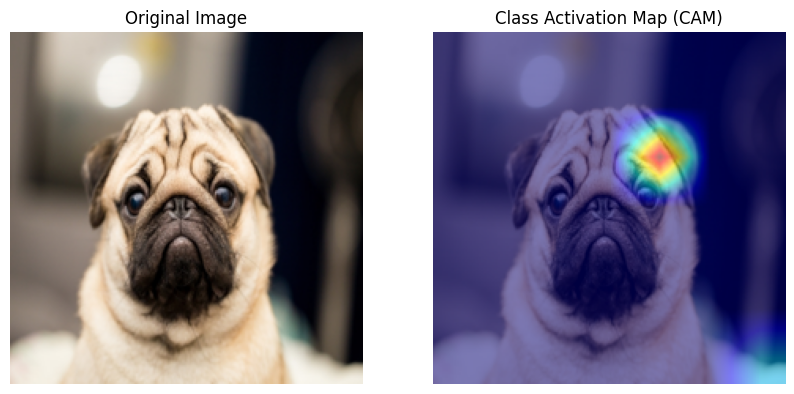

In [ ]:
# Overlay CAM on image
overlayed_img = overlay_cam(img, cam)

# Display the results
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(img)
ax[0].set_title("Original Image")
ax[0].axis('off')
ax[1].imshow(overlayed_img)
ax[1].set_title("Class Activation Map (CAM)")
ax[1].axis('off')
plt.show()


# Compare the result to those in the paper

## Similarities with the Paper Results
 Key Feature Highlighted – The CAM correctly activates around the dog’s eye, similar to the paper’s focus on discriminative object parts.

 Smooth Heatmap Transition – The gradual color blending (blue to red) matches the paper’s visualization approach.

 Proper Image & CAM Overlay – The heatmap is effectively placed over the original image, as done in the paper.

## Differences from the Paper Results
Secondary Activation – Unlike the paper’s CAM, which typically highlights a single key region, this result shows an additional activation on the lower right.

Potential Background Influence – The lower right activation may indicate some influence from background features, differing from the paper’s sharper focus on the main object.

# Simplifications
Used a Pretrained VGG16 Model – Instead of training from scratch as in the paper, I used a pretrained VGG16, making the implementation faster and more practical

Manually Computed CAM Without Modifying the Model – The paper applies Global Average Pooling (GAP), but we extracted feature maps directly and computed CAM manually to keep the model unchanged.

# Brief Writeup

### Key Learnings
- CAM highlights the most important regions influencing the model's classification, providing interpretability.

### Challenges Faced
- Aligning the heatmap with the original image required resizing and proper normalization.

### Potential Improvement
- Implementing Grad-CAM for sharper and more refined activation maps.